In [1]:
# download the MNIST dataset
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
# inspect the data
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


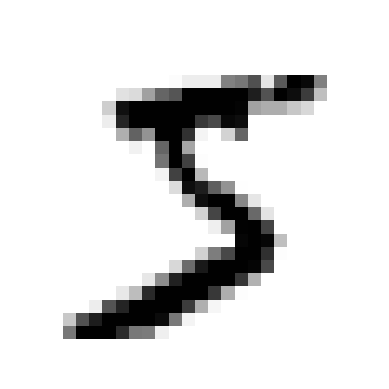

5


In [3]:
# Take a look at one digit from the dataset, and display t 
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X.iloc[0].to_numpy() # X here is a pandas dataframe change to a np
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap= mpl.cm.binary, interpolation = "nearest")
plt.axis("off")
plt.show()

print(y[0])


In [4]:
# cast y into integers, since the pictures are meant to represent integers
import numpy as np

y = y.astype(np.uint8)

In [5]:
# the MNIST dataset is already split into a training set
# first 60,000 are training and 10,000 are test 
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [6]:
# Train a Binary Classifier
# only identify 5 and non-5

# create the target vector
y_train_5 = (y_train == 5) # True for all 5s but not others
y_test_5 = (y_test == 5)

In [7]:
# Train a SGD classifier
from sklearn.linear_model import SGDClassifier 
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

,loss,'hinge'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,None


In [8]:
# try to detect some digit 

#wrape some_digit inside a dataframe for consistency
import pandas as pd

sgd_clf.predict(pd.DataFrame([some_digit], columns=X.columns))

array([ True])

Evaluating the model's performance

In [9]:
# implemement cross-validation
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds =  StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train.iloc[train_index]
  y_train_folds = y_train_5.iloc[train_index]
  X_test_fold = X_train.iloc[test_index]
  y_test_fold = y_train_5.iloc[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


In [10]:
# use the built in function
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

The classifier seems to perform well on cross-validation test, but..

In [11]:
# a classifier that just classifies every single image in the "not-5" class
from sklearn.base import BaseEstimator 

class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    pass
  def predict(self, X):
    return np.zeros((len(X),1), dtype=bool)

In [12]:
# check the accuracy of the model that only output "not 5"
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

it has over 90% accuracy becasue only about 10% of the images are 5

In [13]:
# get a set of predictions for confusion matrix 
from sklearn.model_selection import cross_val_predict 

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)


In [14]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

This classifier is not perfect, but imagine we have a perfect classifier 


In [15]:
y_train_perfect_predictions = y_train_5 # pretend that it is a perfect classifier 
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

In [16]:
# calculate the percision and recall
from sklearn.metrics import precision_score, recall_score
print(f"precision score: {precision_score(y_train_5, y_train_pred)}")
print(f"recall score: {recall_score(y_train_5, y_train_pred)}")


precision score: 0.8370879772350012
recall score: 0.6511713705958311


In [17]:
# Calculate the F1 score
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343847

In [18]:
# make predictions based on a threshold we set
y_scores = sgd_clf.decision_function(pd.DataFrame([some_digit], columns=X.columns))
print(y_scores)

threshold = 0 
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[2164.22030239]
[ True]


In [19]:
# raise the threshold 
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[False]


In [20]:
# deciding which  threshold to use 

# get the scores of all instances in the training set
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")


In [21]:
# with the scores, we compute precision and recall for all possible thresholds
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

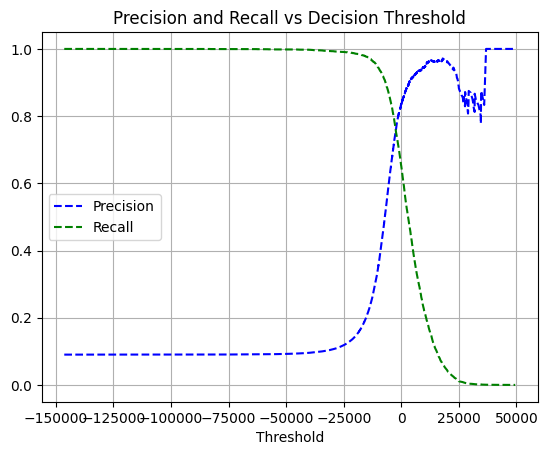

In [22]:
# plot the precision and recall as functions of the threshold value
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
  plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
  plt.xlabel("Threshold")
  plt.legend(loc="center left")
  plt.grid(True)
  plt.title("Precision and Recall vs Decision Threshold")

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [23]:
# search for the lowest threshold that gives at least 90% precision
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
print(threshold_90_precision)

3370.0194991439557


In [24]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
print(f" Precision Score: {precision_score(y_train_5,y_train_pred_90)}")
print(f" Recall Score: {recall_score(y_train_5,y_train_pred_90)}")

 Precision Score: 0.9000345901072293
 Recall Score: 0.4799852425751706
